In [1]:
from datasets import load_dataset

dataset_name = "dim/nfs_pix2pix_1920_1080_v5"
dataset = load_dataset(
    dataset_name,
    cache_dir="/code/dataset/nfs_pix2pix_1920_1080_v5",
)
dataset = dataset["train"]

In [7]:
dataset

Dataset({
    features: ['input_image', 'edit_prompt', 'edited_image'],
    num_rows: 852
})

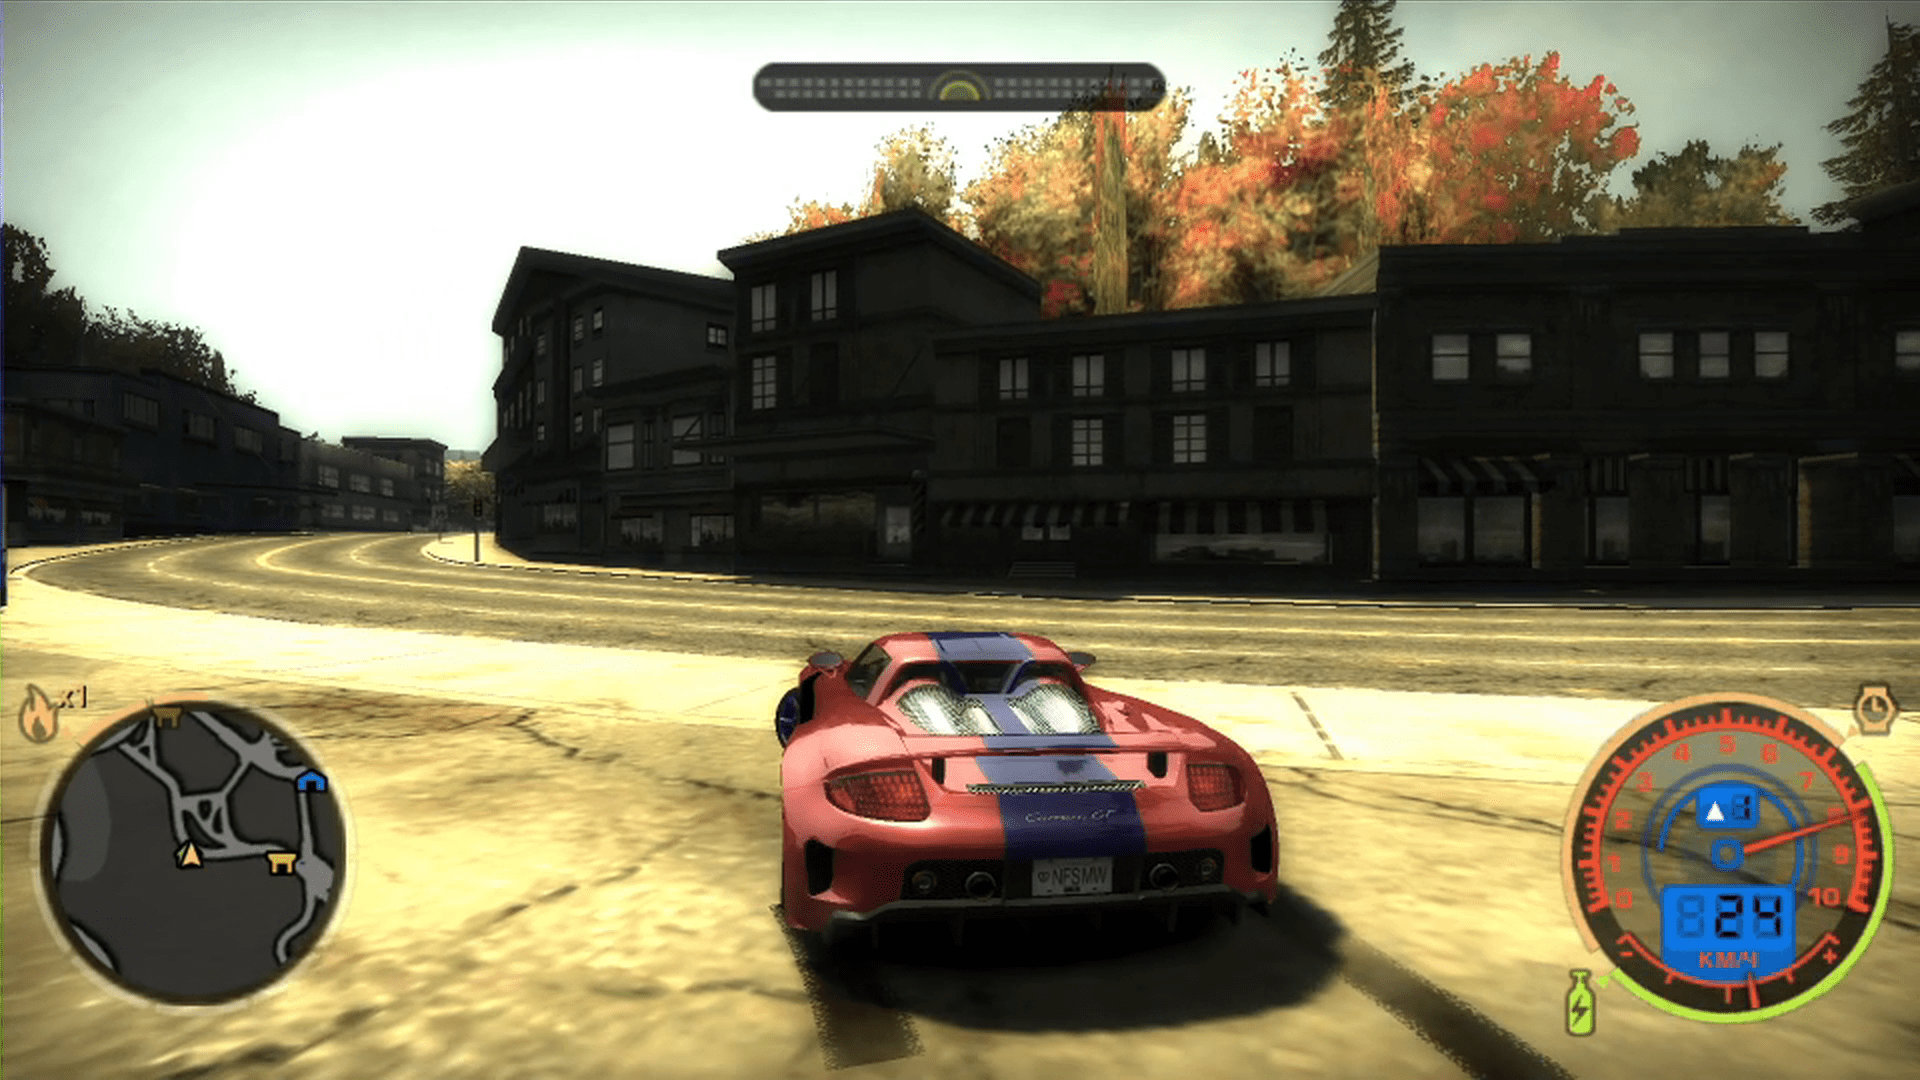

In [2]:
dataset[0]["input_image"]

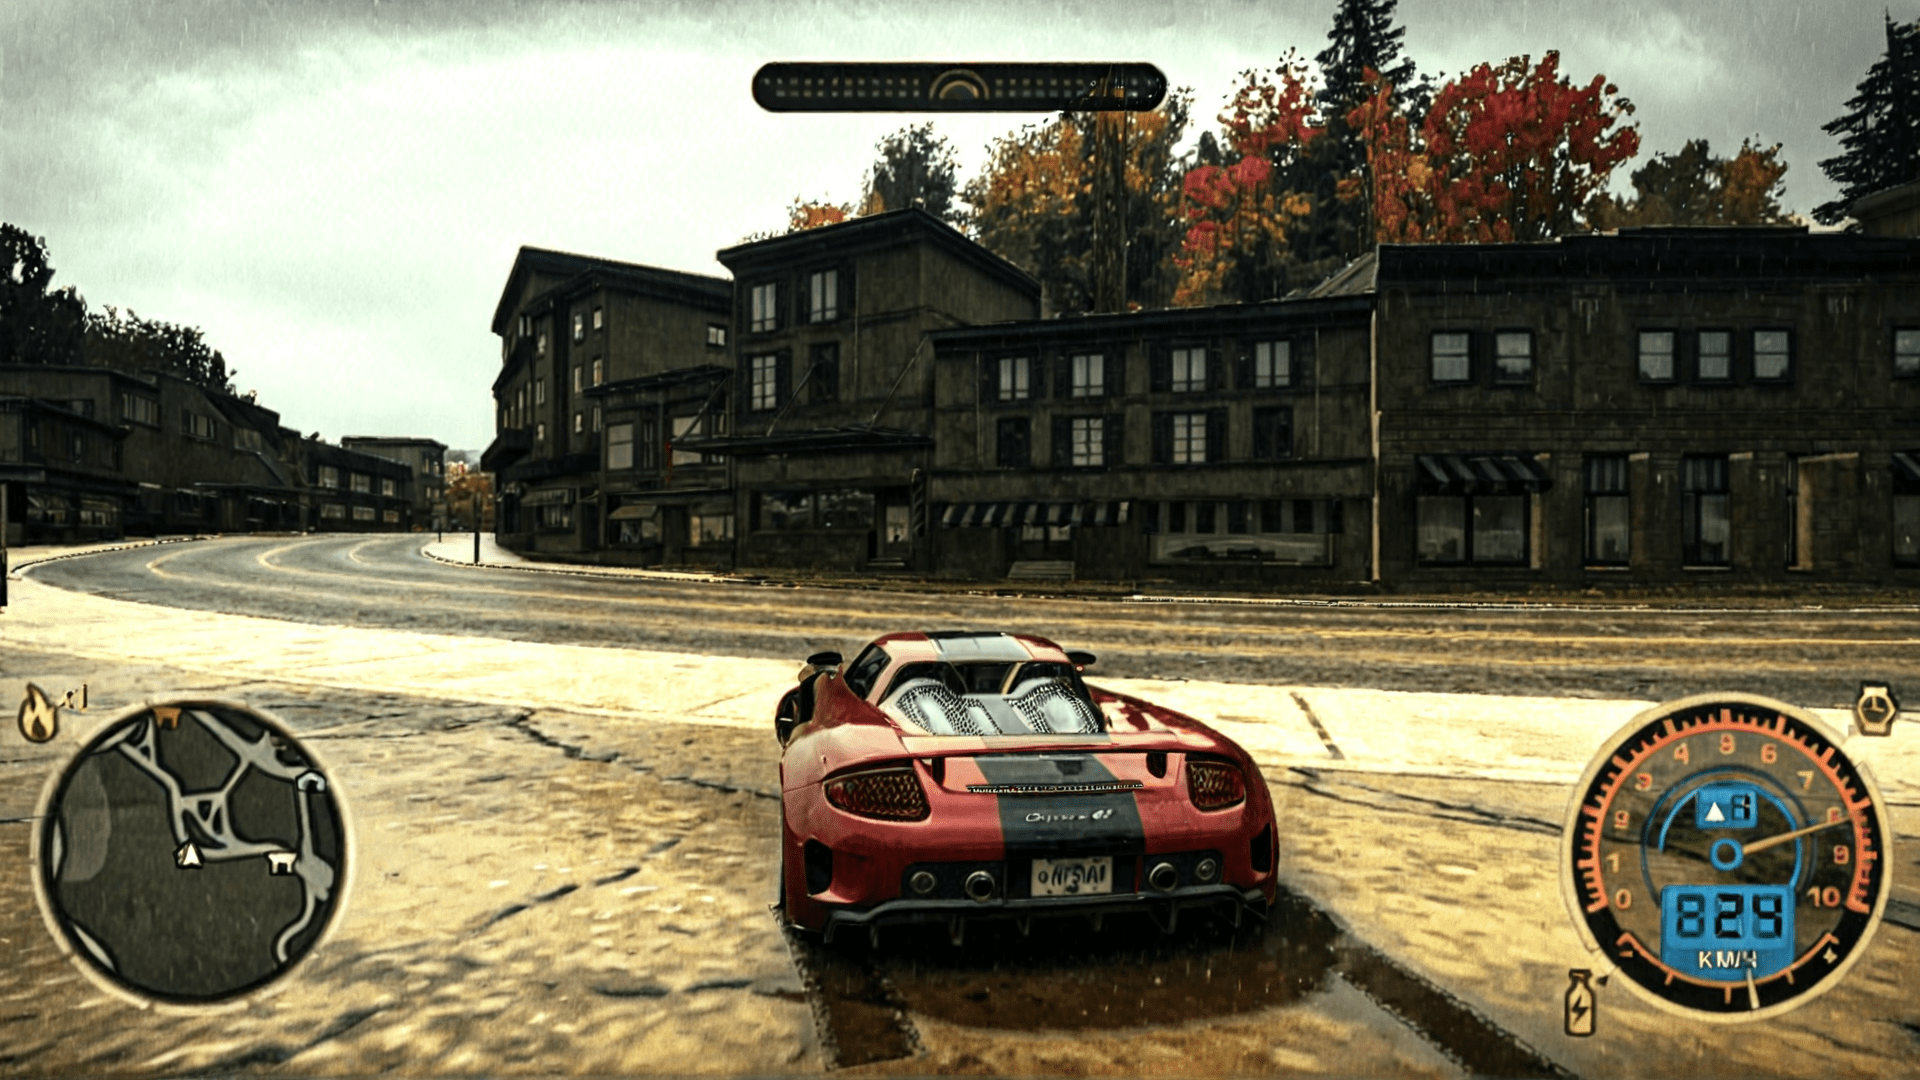

In [3]:
dataset[0]["edited_image"]

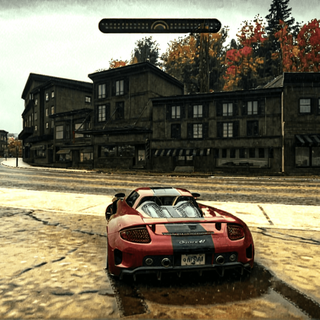

In [81]:
from torchvision import transforms
from diffusers.utils import numpy_to_pil
import numpy as np

interpolation = transforms.InterpolationMode.LANCZOS
random_flip = True
center_crop = True
# resolution = 512
resolution = 320
train_transforms = transforms.Compose(
    [
        transforms.Resize(resolution, interpolation=interpolation),
        transforms.CenterCrop(resolution),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)
image = dataset[0]["edited_image"].convert("RGB")
image = train_transforms(image).unsqueeze(0)

image = (image / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()
image = numpy_to_pil(image)
# image
image[0]

In [82]:
import torch
from torchvision.transforms import v2
from torchvision import tv_tensors

# 1. Define the transform pipeline
transform = v2.Compose(
    [
        v2.Resize(resolution),
        v2.RandomCrop(size=(224, 224)),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        v2.Normalize([0.5], [0.5]),
    ]
)

# 2. Simulate your data (inside your Dataset class)
# Image is RGB, Mask is usually 1-channel
image_raw = transforms.ToTensor()(dataset[0]["input_image"].convert("RGB")).unsqueeze(0)
target = transforms.ToTensor()(dataset[0]["edited_image"].convert("RGB")).unsqueeze(0)

# 3. Wrap them so transforms know how to handle interpolation
# 'Image' uses bilinear, 'Mask' uses nearest-neighbor (to preserve class values)
datapoint = {
    "input": tv_tensors.Image(image_raw),
    "target": tv_tensors.Image(target),
}

# 4. Apply transforms
# The dictionary structure is preserved, and transforms are synchronized
out_dict = transform(datapoint)

print(out_dict["input"].shape)  # torch.Size([3, 224, 224])
print(out_dict["target"].shape)  # torch.Size([1, 224, 224])

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


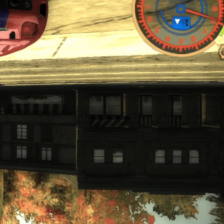

In [83]:
image = out_dict["input"]
image = (image / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()
image = numpy_to_pil(image)
# image
image[0]

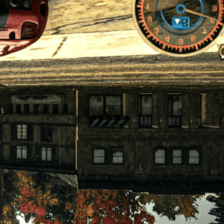

In [84]:
image = out_dict["target"]
image = (image / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()
image = numpy_to_pil(image)
# image
image[0]